In [2]:
import shutil
import sys

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import pipeline
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup


import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


import nltk
from nltk.corpus import wordnet
from deep_translator import GoogleTranslator
from googletrans import Translator


from tqdm import tqdm
import tqdm.notebook as tq

import random
import time

from collections import defaultdict, Counter

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

#nltk.download('wordnet')
#nltk.download('omw-1.4')

translator = Translator()

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# Hyperparameters
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

MAX_LEN = 30
#MAX_LEN = min(30, max(df_train['Utterances'].str.split().apply(len).max(), 50))
BATCH_SIZE = 16
# TRAIN_BATCH_SIZE = 16
# VALID_BATCH_SIZE = 16
# TEST_BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 0.001 #1e-05
THRESHOLD = 0.2 # threshold for the sigmoid

In [4]:
df_data = pd.read_csv('MEISD/MEISD_text.csv')

In [5]:
df_data.head()

,TV Series,Utterances,dialog_ids,uttr_ids,seasons,episodes,start_times,end_times,sentiment,emotion,intensity,emotion2,intensity2,emotion3,intensity3
0,GA,look around you,1,0,1,1,00:02:27:589,00:02:28:567,neutral,neutral,NaN,NaN,NaN,NaN,NaN
1,GA,say hello to your competition,1,1,1,1,00:02:28:910,00:02:30:513,neutral,neutral,NaN,NaN,NaN,NaN,NaN
2,GA,eight of you will switch to an easier specialty,1,2,1,1,00:02:31:387,00:02:34:060,neutral,neutral,NaN,NaN,NaN,NaN,NaN
3,GA,five of you will crack under the pressure,1,3,1,1,00:02:34:134,00:02:36:002,neutral,neutral,NaN,NaN,NaN,NaN,NaN
4,GA,two of you will be asked to leave,1,4,1,1,00:02:36:059,00:02:37:723,neutral,neutral,NaN,NaN,NaN,NaN,NaN


## Data Preprocessing

In [6]:
def check_data_integrity(df):
    print("=== Weryfikacja integralności danych ===")

    print("\n>>> Sprawdzanie brakujących wartości:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

    print("\n>>> Typy danych:")
    print(df.dtypes)

    print("\n>>> Liczba duplikatów:")
    duplicates = df.duplicated().sum()
    print(f"Liczba zduplikowanych wierszy: {duplicates}")

    print("\n>>> Zakres wartości w kolumnach liczbowych:")
    for col in df.select_dtypes(include=[np.number]).columns:
        print(f"{col}: min = {df[col].min()}, max = {df[col].max()}")

    print("\n>>> Unikalne wartości w kolumnach kluczowych:")
    for col in ['emotion', 'emotion2', 'emotion3']:
        if col in df.columns:
            print(f"{col}: {df[col].unique()}")

    print("\nWeryfikacja zakończona.\n")


# Funkcja do weryfikacji kompletności danych
def verify_data_integrity(data):
    issues = []

    if 'combined_emotions' not in data.columns:
        print("Column 'combined_emotions' is missing!")
        return

    for idx, entry in data.iterrows():
        combined_emotions = entry['combined_emotions']

        if not combined_emotions:  
            issues.append(f"Entry {idx} has an empty 'combined_emotions' list.")
        elif not isinstance(combined_emotions, list):  
            issues.append(f"Entry {idx} has 'combined_emotions' which is not a list.")

    if issues:
        print("Data integrity check failed:")
        for issue in issues:
            print(issue)
    else:
        print("All entries in 'combined_emotions' are valid!")

check_data_integrity(df_data)

=== Weryfikacja integralności danych ===

>>> Sprawdzanie brakujących wartości:
intensity      3568
emotion2      11128
intensity2    11129
emotion3      19950
intensity3    19950
dtype: int64

>>> Typy danych:
TV Series       object
Utterances      object
dialog_ids       int64
uttr_ids         int64
seasons          int64
episodes         int64
start_times     object
end_times       object
sentiment       object
emotion         object
intensity       object
emotion2        object
intensity2      object
emotion3        object
intensity3     float64
dtype: object

>>> Liczba duplikatów:
Liczba zduplikowanych wierszy: 0

>>> Zakres wartości w kolumnach liczbowych:
dialog_ids: min = 1, max = 1125
uttr_ids: min = 0, max = 40
seasons: min = 1, max = 10
episodes: min = 1, max = 26
intensity3: min = 1.0, max = 3.0

>>> Unikalne wartości w kolumnach kluczowych:
emotion: ['neutral' 'acceptance' 'disgust' 'surprise' 'joy' 'sadness' 'anger'
 'like' 'fear' 'acceptance ' 'faer' 'Fear ' 'fear ' 'Fe

In [7]:
unique_emotions = set(df_data['emotion'].unique()) | set(df_data['emotion2'].unique()) | set(df_data['emotion3'].unique())
print(unique_emotions)

{' anger', 'Joy', '  disgust', 'acceptance ', 'digust', 'neutral ', 'Anger', 'disgust', 'anger', ' surprise', 'Disgust', 'anger1', nan, 'acceptance', 'Fera', 'sadness', 'faer', 'Fear ', ' disgust', 'Sadness ', 'Surprise ', 'an', 'Neutral ', 'Surprise', 'sadnes', 'neutral', 'ANGER', 'asadness', 'Fear', 'Sadness', 'fear ', 'surprise', 'joy', 'like', 'sadness ', 'Neutral', 'l', ' sadness', 'sur', 'fear'}


In [8]:
emotion_map = {
    'neutral': 0, 'Neutral': 0, 'Neutral ': 0, 'neutral ': 0,
    'acceptance': 1, 'acceptance ': 1,
    'disgust': 2, 'Disgust': 2, ' disgust': 2, '  disgust': 2, 'digust': 2,
    'surprise': 3, 'Surprise': 3, ' surprise': 3, 'Surprise ': 3, 'sur': 3,
    'joy': 4, 'Joy': 4, 'like': 4,
    'sadness': 5, 'Sadness': 5, ' sadness': 5, 'Sadness ': 5, 'sadness ': 5, 'sadnes': 5, 'asadness': 5,
    'anger': 6, 'Anger': 6, ' anger': 6, 'ANGER': 6, 'anger1': 6, 'an': 6,
    'fear': 8, 'Fear': 8, 'fear ': 8, 'Fear ': 8, 'faer': 8, 'Fera': 8,
    'l': None, np.nan: None
}

data_emotion = pd.DataFrame()
data_emotion['Utterances'] = df_data['Utterances']

data_emotion['target1'] = df_data['emotion'].map(emotion_map)
data_emotion['target2'] = df_data['emotion2'].map(emotion_map)
data_emotion['target3'] = df_data['emotion3'].map(emotion_map)


def fill_nans(row):
    if row.isna().sum() == 2 and row.count() == 1:
        row = row.fillna(row.dropna().iloc[0])

    elif row.isna().sum() == 1 and row.count() == 2:
        row = row.fillna(row.dropna().iloc[0])

    return row


data_emotion[['target1', 'target2', 'target3']] = data_emotion[['target1', 'target2', 'target3']].apply(fill_nans, axis=1)

data_emotion['target1'] = data_emotion['target1'].astype(int)
data_emotion['target2'] = data_emotion['target2'].astype(int)
data_emotion['target3'] = data_emotion['target3'].astype(int)

In [9]:
data_emotion.head(5)

,Utterances,target1,target2,target3
0,look around you,0,0,0
1,say hello to your competition,0,0,0
2,eight of you will switch to an easier specialty,0,0,0
3,five of you will crack under the pressure,0,0,0
4,two of you will be asked to leave,0,0,0


In [10]:
data_emotion['combined_emotions'] = data_emotion[['target1', 'target2', 'target3']].apply(lambda x: x.dropna().unique().astype(int).tolist(), axis=1)

In [11]:
verify_data_integrity(data_emotion)

All entries in 'combined_emotions' are valid!


In [12]:
# One-hot encoding
mlb_emotion = MultiLabelBinarizer()
emotion_binarized = mlb_emotion.fit_transform(data_emotion['combined_emotions'])
emotion_df = pd.DataFrame(emotion_binarized, columns=[f'emotion_{i+1}' for i in range(emotion_binarized.shape[1])])

In [13]:
check_data_integrity(emotion_df)

=== Weryfikacja integralności danych ===

>>> Sprawdzanie brakujących wartości:
Series([], dtype: int64)

>>> Typy danych:
emotion_1    int32
emotion_2    int32
emotion_3    int32
emotion_4    int32
emotion_5    int32
emotion_6    int32
emotion_7    int32
emotion_8    int32
dtype: object

>>> Liczba duplikatów:
Liczba zduplikowanych wierszy: 19970

>>> Zakres wartości w kolumnach liczbowych:
emotion_1: min = 0, max = 1
emotion_2: min = 0, max = 1
emotion_3: min = 0, max = 1
emotion_4: min = 0, max = 1
emotion_5: min = 0, max = 1
emotion_6: min = 0, max = 1
emotion_7: min = 0, max = 1
emotion_8: min = 0, max = 1

>>> Unikalne wartości w kolumnach kluczowych:

Weryfikacja zakończona.


In [14]:
multi_label_binarizer_MEISD = pd.concat([data_emotion['Utterances'], emotion_df], axis=1)
multi_label_binarizer_MEISD

,Utterances,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8
0,look around you,1,0,0,0,0,0,0,0
1,say hello to your competition,1,0,0,0,0,0,0,0
2,eight of you will switch to an easier specialty,1,0,0,0,0,0,0,0
3,five of you will crack under the pressure,1,0,0,0,0,0,0,0
4,two of you will be asked to leave,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
20012,"oh, that's right, you're a woman and you need ...",0,0,1,0,0,0,1,0
20013,i'll try again,0,0,1,0,0,0,1,0
20014,"please, pam, reconsider and have a bagel",0,1,1,0,0,0,0,0
20015,i have an early lunch,0,0,1,0,0,0,1,0


## Data Augmentation

In [ ]:
# 1. Synonym Replacement
def synonym_replacement(text):
    words = text.split()
    new_words = words[:]
    num_replacements = max(1, len(words) // 5)  # Replace about 20% of words
    random_words = random.sample(words, num_replacements)

    for word in random_words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            #synonym = synonyms[0].lemmas()[0].name()  # Take first synonym
            synonym = random.choice(synonyms).lemmas()[0].name()
            if synonym != word:  # Avoid replacement if the synonym is identical
                new_words = [synonym if w == word else w for w in new_words]
    return ' '.join(new_words)


# 2. Random Insertion
def random_insertion(text, n=1):
    words = text.split()
    for _ in range(n):
        new_word = random.choice(words)
        insert_pos = random.randint(0, len(words))
        words.insert(insert_pos, new_word)
    return ' '.join(words)


# 3. Random Deletion
def random_deletion(text, p=0.3):
    words = text.split()
    if len(words) == 1:
        return text  # Avoid deleting single-word text
    new_words = [word for word in words if random.uniform(0, 1) > p]
    if not new_words:
        return random.choice(words)  # Return one word if all words are deleted
    return ' '.join(new_words)

# 4. Back Translation
def back_translation(text, src_lang='en', mid_lang='fr', max_retries=3):
    attempt = 0
    while attempt < max_retries:
        try:
            translated = GoogleTranslator(source=src_lang, target=mid_lang).translate(text)
            back_translated = GoogleTranslator(source=mid_lang, target=src_lang).translate(translated)
            return back_translated
        except Exception as e:
            print(f"Back translation error on attempt {attempt + 1}: {e}")
            attempt += 1
            time.sleep(1)
    raise ValueError("Back translation failed")

In [ ]:
def augment_text(text, num_augments=2):
    augmented_texts = []
    for _ in range(num_augments):
        augmentation_choice = random.choice(['synonym', 'insertion', 'deletion', 'back_translation'])
        if augmentation_choice == 'synonym':
            augmented_texts.append(synonym_replacement(text))
        elif augmentation_choice == 'insertion':
            augmented_texts.append(random_insertion(text))
        elif augmentation_choice == 'deletion':
            augmented_texts.append(random_deletion(text))
        elif augmentation_choice == 'back_translation':
            augmented_texts.append(back_translation(text))
    return augmented_texts

In [ ]:
label_sums = multi_label_binarizer_MEISD.iloc[:, 1:].sum()

plt.figure(figsize=(10, 6))
label_sums.plot(kind='bar', color='skyblue')
plt.title('Rozkład klas (emocji)')
plt.xlabel('Emocje')
plt.ylabel('Liczba próbek')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Split into train and test

In [15]:
# split into train and test
df_train, df_temp = train_test_split(multi_label_binarizer_MEISD, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_temp, random_state=88, test_size=0.50, shuffle=True)

In [16]:
df_train.head()

,Utterances,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8
13858,had you asked a couple of weeks ago,1,0,0,0,0,0,0,0
14789,Yeah! Richard!,0,0,0,0,0,0,1,0
17589,young benjamin here knows what's coming,0,0,1,0,0,0,1,0
8549,i don't see why they had to keep my credit car...,0,0,0,0,0,1,1,0
18378,between us,0,0,0,0,0,1,0,0


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14011 entries, 13858 to 15063
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Utterances  14011 non-null  object
 1   emotion_1   14011 non-null  int32 
 2   emotion_2   14011 non-null  int32 
 3   emotion_3   14011 non-null  int32 
 4   emotion_4   14011 non-null  int32 
 5   emotion_5   14011 non-null  int32 
 6   emotion_6   14011 non-null  int32 
 7   emotion_7   14011 non-null  int32 
 8   emotion_8   14011 non-null  int32 
dtypes: int32(8), object(1)
memory usage: 656.8+ KB


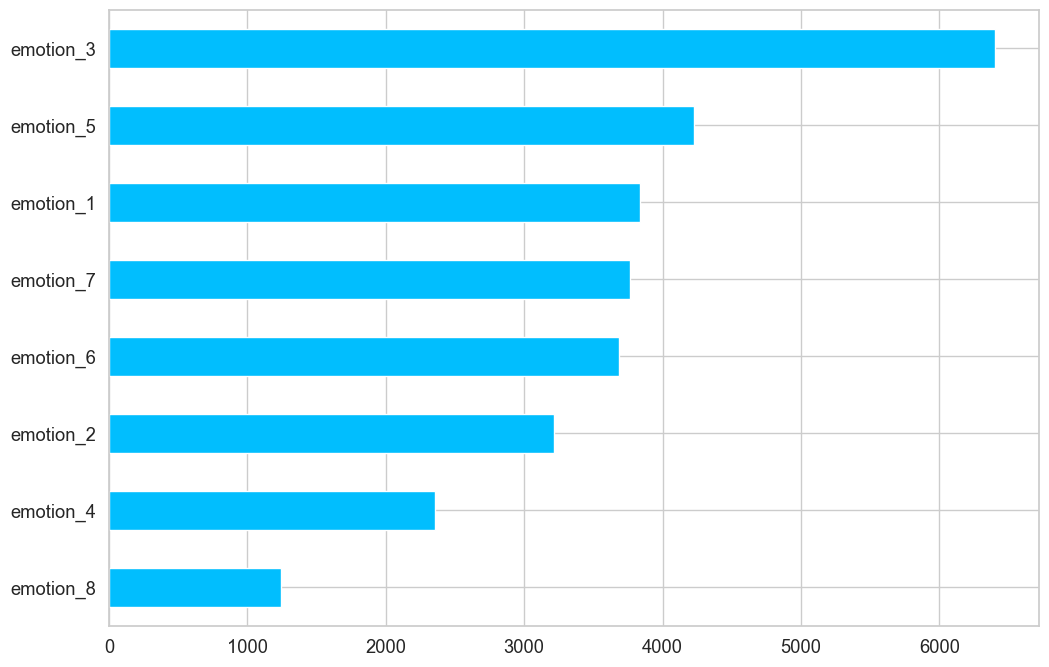

In [18]:
LABEL_COLUMNS = multi_label_binarizer_MEISD.columns.tolist()[1:]
multi_label_binarizer_MEISD[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [19]:
class_counts = df_train[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
                         'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].sum(axis=0)

max_count = class_counts.max()
class_counts

emotion_1    2701
emotion_2    2236
emotion_3    4509
emotion_4    1674
emotion_5    2941
emotion_6    2563
emotion_7    2631
emotion_8     842
dtype: int64

In [20]:
def check_balance(class_counts):
    """
    Analizuje balans w danych na podstawie liczby próbek w każdej klasie.

    Args:
        class_counts (list or dict): Liczność próbek w klasach. Może być listą liczb
                                     lub słownikiem {nazwa_klasy: liczba_próbek}.
    Returns:
        dict: Słownik z obliczonymi miarami balansu:
              - Rozpiętość (range)
              - Odchylenie standardowe (std)
              - Średnia liczba próbek (mean)
              - Największa klasa (max_class)
              - Najmniejsza klasa (min_class)
              - Interpretacja (interpretation)
    """
    if isinstance(class_counts, dict):
        class_counts = list(class_counts.values())

    max_count = max(class_counts)
    min_count = min(class_counts)
    mean_count = np.mean(class_counts)
    std_count = np.std(class_counts)
    range_count = max_count - min_count

    # Interpretacja balansu
    if std_count < 0.1 * mean_count:
        interpretation = "Dane są bardzo dobrze zbalansowane."
    elif std_count < 0.3 * mean_count:
        interpretation = "Dane są umiarkowanie zbalansowane."
    else:
        interpretation = "Dane są niezbalansowane."

    return {
        "range": range_count,
        "std": std_count,
        "mean": mean_count,
        "max_class": max_count,
        "min_class": min_count,
        "interpretation": interpretation
    }

In [21]:
check_balance(class_counts)

{'range': 3667,
 'std': 986.9050660397888,
 'mean': 2512.125,
 'max_class': 4509,
 'min_class': 842,
 'interpretation': 'Dane są niezbalansowane.'}

In [22]:
from tqdm import tqdm

def augment_multilabel_data(df, label_columns, augment_text, num_augments=2):
    """
    Augments multilabel data to balance class distributions, ignoring samples with the most frequent class.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'Utterances' column and label columns.
    - label_columns (list): List of column names corresponding to binary label columns.
    - augment_text (callable): Function to augment text. Should take a string and return a list of augmented strings.
    - num_augments (int): Number of augmented samples to generate per original sample.

    Returns:
    - pd.DataFrame: Augmented DataFrame with balanced class distributions.
    """
    # Calculate class counts
    class_counts = {label: df[label].sum() for label in label_columns}
    max_count = max(class_counts.values())
    most_frequent_class = max(class_counts, key=class_counts.get)

    print(f"Class counts: {class_counts}")
    print(f"Maximum class count: {max_count}")
    print(f"Most frequent class: {most_frequent_class} (ignoring samples with this label)")

    # Initialize storage for augmented data
    augmented_data = {'Utterances': [], **{label: [] for label in label_columns}}

    for label in label_columns:
        if label == most_frequent_class:
            print(f"Skipping augmentation for the most frequent class '{label}'.")
            continue  # Skip augmenting the most frequent class

        # Select rows where the current label is 1
        class_subset = df[df[label] == 1]
        augmented_data['Utterances'].extend(class_subset['Utterances'])
        for lbl in label_columns:
            augmented_data[lbl].extend(class_subset[lbl])

        # Calculate how many samples to augment
        num_to_augment = max_count - len(class_subset)

        if num_to_augment > 0:
            print(f"Augmenting class '{label}' with {num_to_augment} samples.")
            for _, row in tqdm(class_subset.iterrows(), total=len(class_subset), desc=f"Augmenting {label}"):
                if num_to_augment <= 0:
                    break

                # Perform text augmentation
                new_texts = augment_text(row['Utterances'], num_augments=num_augments)
                for new_text in new_texts:
                    if num_to_augment <= 0:
                        break
                    augmented_data['Utterances'].append(new_text)

                    # Add the multilabels for the augmented data
                    for lbl in label_columns:
                        augmented_data[lbl].append(row[lbl])

                    num_to_augment -= 1

    # Create a new DataFrame with augmented data
    augmented_df = pd.DataFrame(augmented_data)
    return augmented_df


In [ ]:
# ## Augmentation
# augmented_df = augment_multilabel_data(
#     df=df_train,
#     label_columns=[f"emotion_{i}" for i in range(1, 9)],
#     augment_text=augment_text,
#     num_augments=2
# )
# 
# print(augmented_df)

In [ ]:
# class_counts = augmented_df[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
#                          'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].sum(axis=0)
# max_count = class_counts.max()
# class_counts

In [ ]:
# check_balance(class_counts)

In [ ]:
# augmented_df.to_csv('balanced_augmented_emotion_data.csv', index=False)

## Read Augmetnation data

In [ ]:
# augmented_df = pd.read_csv('balanced_augmented_emotion_data.csv')

In [ ]:
# df_train_augmented = pd.concat([df_train, augmented_df], ignore_index=True)
# 
# print(df_train_augmented[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
#                           'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].sum(axis=0))

## Run from here

In [23]:
print(f"Original train size: {multi_label_binarizer_MEISD.shape}")
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Original train size: (20017, 9)
Train: (14011, 9), Test: (3003, 9), Valid: (3003, 9)


In [24]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                  max_length = MAX_LEN,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

{'input_ids': tensor([[  101,  1284,  1132,  5193,   139,  9637,  1942, 22559, 17260,   119,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]])}

In [25]:
LABEL_COLUMNS = df_train.columns.tolist()[1:]

In [26]:
LABEL_COLUMNS

['emotion_1',
 'emotion_2',
 'emotion_3',
 'emotion_4',
 'emotion_5',
 'emotion_6',
 'emotion_7',
 'emotion_8']

In [27]:
class EmotionalDataset(Dataset):
    def __init__(self,
                data: pd.DataFrame,
                tokenizer: BertTokenizer,
                max_token_len: int = 128):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        # Extract text and labels
        text = data_row['Utterances']
        labels = data_row[LABEL_COLUMNS].astype(float).values  # Convert labels to float

        # Tokenize text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Return dictionary
        return dict(
            utterances=text,
            input_ids=encoding["input_ids"].squeeze(),
            attention_mask=encoding["attention_mask"].squeeze(),
            labels=torch.tensor(labels, dtype=torch.float)  # Explicitly set tensor dtype
        )


In [31]:
next(iter(train_dataset))

{'utterances': 'had you asked a couple of weeks ago',
 'input_ids': tensor([ 101, 1125, 1128, 1455,  170, 2337, 1104, 2277, 2403,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]),
 'labels': tensor([1., 0., 0., 0., 0., 0., 0., 0.])}

In [29]:
sample_item["utterances"]

'had you asked a couple of weeks ago'

In [28]:
train_dataset = EmotionalDataset(df_train, tokenizer, max_token_len=MAX_LEN)
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['utterances', 'input_ids', 'attention_mask', 'labels'])

In [30]:
sample_item["labels"]

tensor([1., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=True)

In [ ]:
# from time import time
# 
# start_time = time()
# for i, batch in enumerate(DataLoader(train_dataset, batch_size=1, num_workers=0)):
#     if i == 10:  # Zatrzymaj po 10 iteracjach
#         break
# end_time = time()
# print(f"Time for 10 batches: {end_time - start_time:.2f} seconds")


In [33]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=0)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 30]), torch.Size([8, 30]))

In [34]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [35]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 30, 768]), torch.Size([8, 768]))

In [36]:
bert_model.config.hidden_size

768

In [59]:
class EmotionalDataModule(pl.LightningDataModule):

    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = EmotionalDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = EmotionalDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=2
        )


In [60]:
data_module = EmotionalDataModule(
    df_train,
    df_test,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_LEN
)

## Model

In [39]:
class EmotionalTagger(pl.LightningModule):

    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def training_epoch_end(self, outputs):

        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)

        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)

        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:, i], labels[:, i])
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


    def configure_optimizers(self):

        optimizer = AdamW(self.parameters(), lr=2e-5)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )

        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )

## Optimizer scheduler

In [40]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]['lr'])

D:\conda\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


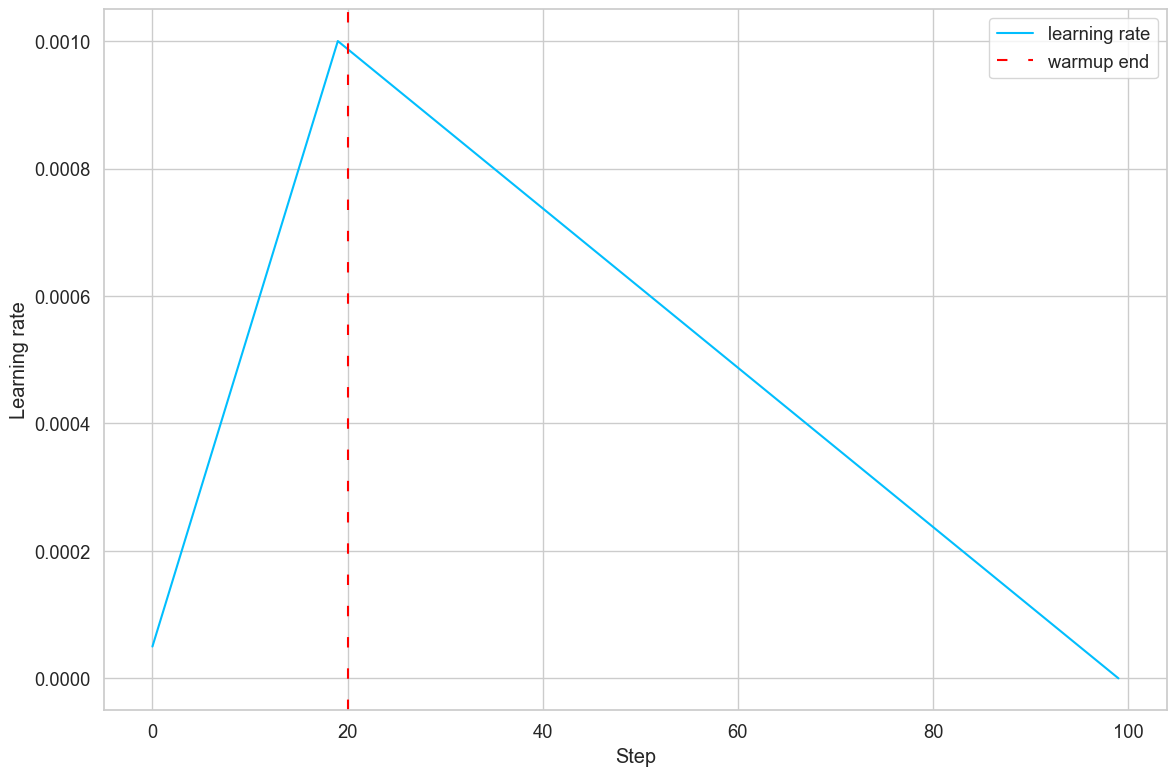

In [41]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [42]:
steps_per_epoch=len(train_dataset) // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS

In [57]:
steps_per_epoch

875

In [43]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(350, 1750)

In [44]:
model = EmotionalTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

## Evaluation

In [45]:
criterion = nn.BCELoss()

prediction = torch.FloatTensor(
    [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
    [1., 0., 0., 0., 1., 0.]
)

In [46]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [47]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

In [48]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.5950, 0.4538, 0.3843, 0.5120, 0.5147, 0.4869, 0.5258, 0.2400],
        [0.5927, 0.4759, 0.3898, 0.4746, 0.5165, 0.4374, 0.5069, 0.2367],
        [0.5802, 0.4849, 0.4031, 0.4752, 0.5078, 0.4485, 0.5072, 0.2486],
        [0.5847, 0.4369, 0.4075, 0.5005, 0.4806, 0.5089, 0.5103, 0.2792],
        [0.5635, 0.5094, 0.3721, 0.4662, 0.5278, 0.4865, 0.4913, 0.2746],
        [0.5709, 0.4772, 0.4157, 0.4605, 0.5085, 0.4386, 0.4812, 0.2720],
        [0.5763, 0.4809, 0.4033, 0.4604, 0.5087, 0.4640, 0.4713, 0.2582],
        [0.5945, 0.4559, 0.3752, 0.4762, 0.5201, 0.4591, 0.5132, 0.2297]],
       grad_fn=<SigmoidBackward0>)

In [49]:
criterion(predictions, sample_batch["labels"])

tensor(0.6224, grad_fn=<BinaryCrossEntropyBackward0>)

## ROC Curve

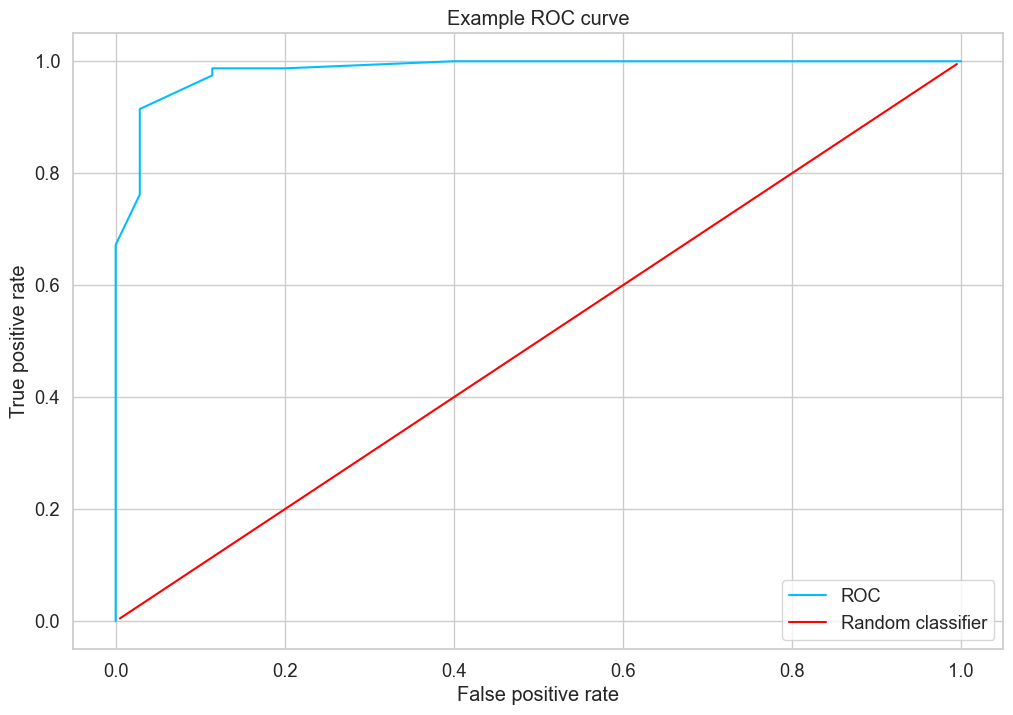

In [50]:
from sklearn import metrics

fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]

tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

## Training

In [51]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [52]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

In [53]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [54]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs=EPOCHS,
    #accelerator="cpu",
    #devices=1,
    #gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [61]:
for batch in data_module.train_dataloader():
    print(batch)
    break

TypeError: EmotionalDataModule.train_dataloader() takes 1 positional argument but 2 were given

In [ ]:
trainer.fit(model, data_module)

In [ ]:
trainer.test()

## Predictions

In [ ]:
trained_model = EmotionalTagger.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

In [ ]:
test_comment = "Hi, I'm Meredith and I'm an alch... good at supplier relations"

encoding = tokenizer.encode_plus(
    test_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
    print(f"{label}: {prediction}")


In [ ]:
THRESHOLD = 0.5

test_comment = "You are such a loser! You'll regret everything you've done to me!"
encoding = tokenizer.encode_plus(
    test_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
    if prediction < THRESHOLD:
        continue
    print(f"{label}: {prediction}")


## Evaluation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = EmotionalDataset(
    df_valid,
    tokenizer,
    max_token_len=MAX_LEN
)

predictions = []
labels = []

for item in tqdm(val_dataset):
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()


In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
    tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
    print(f"{name}: {tag_auroc}")


In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
    y_true,
    y_pred,
    target_names=LABEL_COLUMNS,
    zero_division=0
))
